The problem of approximating Fourier series for arbitrary group transformations (including spherical traversing & rotation) can be factored by first building a linear operator from a random discrete/raster signal that resembles the same cyclic convolution process, add the symmetric/Hermitian matrix constraint to ensure that all its eigenvectors are real (to make observing the pattern easier), then compute all its eigenvectors and watch the pattern.

E.g. if you have a random 1D signal:

$$
[v_1, v_2, v_3, v_4]
$$

- Create linear operator (with row-vector convention, because in convolution it is the first operand):
  $$
  \begin{bmatrix}
   v_1 & v_2 & v_3 & v_4 \\
   v_4 & v_1 & v_2 & v_3 \\
   v_3 & v_4 & v_1 & v_2 \\
   v_2 & v_3 & v_4 & v_1 \\
  \end{bmatrix}
  $$

- add the mirror part to make it symmetric
  $$
  \begin{bmatrix}
   v_1 & v_2 & v_3 & v_4 & v_3 & v_2\\
   v_2 & v_1 & v_2 & v_3 & ... \\
   v_3 & v_2 & v_1 & v_2 & ... \\
   v_4 & v_3 & v_2 & v_1 & ... \\
   v_3 & ... \\
   v_2 & ... \\
  \end{bmatrix}
  $$

The following code does exactly this

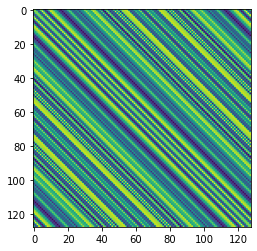

In [22]:
import torch
from torch import Tensor
from matplotlib import pyplot

# random circulant matrix

nDim = 128
base = torch.rand([nDim])

for i in range(0, int(nDim/2) ):
    base[nDim - i - 1] = base[i + 1]

circ=lambda v:torch.cat([f:=v.flip(0),f[:-1]]).unfold(0,len(v),1).flip(0)

matrix = circ(base)

pyplot.imshow(matrix)

- Compute eigenvectors. Unfortunately, by default all eigenvectors will be scrambled, as they are ranked by eigenvalues (in descending order) which is completely random,  to actually observe the pattern we'll need to rank them again by their Laplacians (a.k.a. "smoothness", a.k.a the following):
  $$
  \sum \nabla^2 f
  $$

In [23]:
def laplacian(vec: Tensor):
    shift1 = torch.roll(vec, 1, 0)
    diff = shift1 - vec
    return torch.norm(diff).item()

print(laplacian(torch.rand(5)))

0.9426694512367249


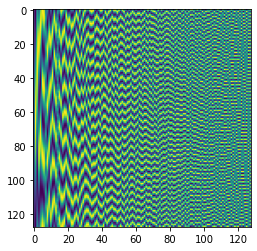

In [24]:
eigs = torch.eig(matrix, eigenvectors=True)

columnLaplacians = Tensor()

columnIs = torch.Tensor(range(0, nDim))

def _tt(i: float):
    result = laplacian(eigs.eigenvectors[:,int(i)])
    return result

eigVNorms = columnIs.apply_(_tt)

order = torch.sort(eigVNorms)

eigVSorted = eigs.eigenvectors[:, order.indices]

pyplot.imshow(eigVSorted)

For other cases we'll need to figure out how to convert other kinds of convolution on group (G-conv) into linear operators. E.g. for 2D discrete signal:
$$
\begin{bmatrix}
 v_1 & v_2 \\
 v_3 & v_4 \\
\end{bmatrix}
$$
It can still be flatten in the same 4D vector, but their cyclic shifted versions are:
$$
\begin{bmatrix}
 v_3 & v_4 \\
 v_1 & v_2 \\
\end{bmatrix} (up),
\begin{bmatrix}
 v_2 & v_1 \\
 v_4 & v_3 \\
\end{bmatrix} (right),
\begin{bmatrix}
 v_3 & v_1 \\
 v_4 & v_2 \\
\end{bmatrix} (both)
$$
After flattening, the linear operator looks very different. So if you want to see a pattern, you can try investigating from here

Then we will have gradually more complex discrete G-conv coming